In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
torch.__version__

'2.0.1+cu117'

In [4]:
# create parameters 
weights = 0.7
bias = 0.3

# create data: y = bias + weights*X
X = torch.arange(0, 1, 0.02)
y = bias + weights*X
X.shape, y.shape

(torch.Size([50]), torch.Size([50]))

In [5]:
# divide the data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([40]), torch.Size([10]), torch.Size([40]), torch.Size([10]))

In [6]:
# function to plot the data
def plot_predictions(train_data=X_train, train_lables=y_train, test_data=X_test, test_lables=y_test, predictions=np.array(None)):
    # plt.figure(figsize=(7,7))
    plt.scatter(train_data, train_lables, c='b', label='Training data', s=4)
    plt.scatter(test_data, test_lables, c='g', label='Test data', s=4)

    if predictions.any():
        plt.scatter(test_data, predictions, c='r', label='Predictions', s=4)
    
    plt.legend()

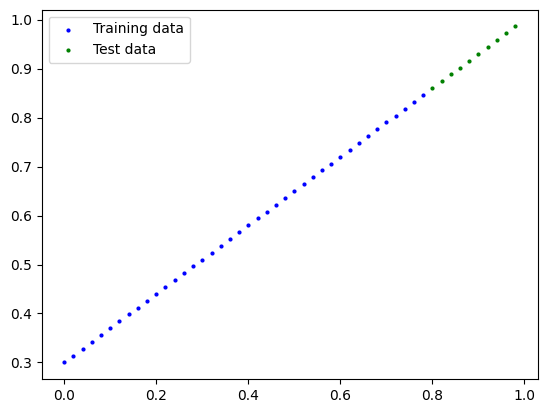

In [7]:
plot_predictions()

In [8]:
# Linear regression model
class LinearRegression(nn.Module):
    
    # constructor
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1), requires_grad=True)
        self.bias = nn.Parameter(torch.randn(1), requires_grad=True)

    # forward method
    def forward(self, x: torch.Tensor)->torch.Tensor:
        return self.bias + self.weights * x

In [9]:
torch.manual_seed(42)

model = LinearRegression()

# check the parameters
list(model.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [10]:
# check the named parameters
model.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [11]:
# predict outputs - setting torch to inference mode will make it run faster as it no longer keeps a track of parameters for gradient descent function 
with torch.inference_mode():
    y_pred = model(X_test)

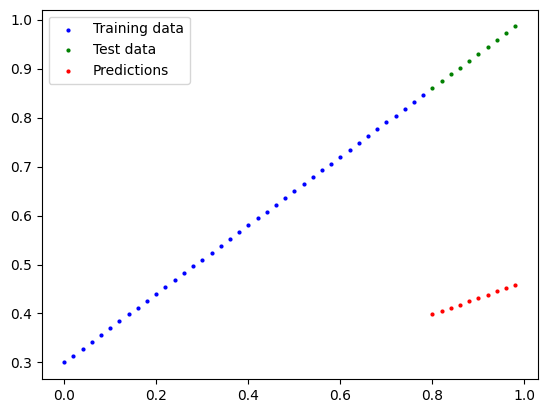

In [12]:
plot_predictions(predictions=y_pred)

We have seen that the predictions are far away from ideal scenario. 

Hence we will be training our model to predict better 

In [13]:
# loss function
loss_fn = nn.L1Loss()

# optimizer
optimizer = torch.optim.SGD(params = model.parameters(), lr=0.01)

In [14]:
# Training loop
epochs = 200

# store values
epoch_count = []
train_loss_vals = []
test_loss_vals = []

for epoch in range(epochs+1):
    model.train()

    # forward pass
    y_pred = model(X_train)

    # calculate the loss
    loss = loss_fn(y_pred, y_train)

    # optimizer accumulates gradients in each epoch that needs to be reset to 0
    optimizer.zero_grad()

    # loss.backward() computes dloss/dx aka gradient (slope) for every parameter x which has requires_grad=True. These are accumulated into x.grad for every parameter x
    loss.backward()

    # perform gradient descent 
    optimizer.step()

    # eval mode, this stops some background fxns like dropout and batchnorm which aren't req in evaluation
    model.eval()

    # this mode will stop calc gradients to speed up the process
    with torch.inference_mode():

        # forward pass
        y_pred = model(X_test)

        test_loss = loss_fn(y_pred, y_test)

    if epoch % 10 == 0:
        epoch_count.append(epoch)
        train_loss_vals.append(loss.detach().numpy())
        test_loss_vals.append(test_loss.detach().numpy())
        print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")


Epoch: 0 | Loss: 0.31288138031959534 | Test loss: 0.48106518387794495
Epoch: 10 | Loss: 0.1976713240146637 | Test loss: 0.3463551998138428
Epoch: 20 | Loss: 0.08908725529909134 | Test loss: 0.21729660034179688
Epoch: 30 | Loss: 0.053148526698350906 | Test loss: 0.14464017748832703
Epoch: 40 | Loss: 0.04543796554207802 | Test loss: 0.11360953003168106
Epoch: 50 | Loss: 0.04167863354086876 | Test loss: 0.09919948130846024
Epoch: 60 | Loss: 0.03818932920694351 | Test loss: 0.08886633068323135
Epoch: 70 | Loss: 0.03476089984178543 | Test loss: 0.0805937647819519
Epoch: 80 | Loss: 0.03132382780313492 | Test loss: 0.07232122868299484
Epoch: 90 | Loss: 0.02788739837706089 | Test loss: 0.06473556160926819
Epoch: 100 | Loss: 0.024458957836031914 | Test loss: 0.05646304413676262
Epoch: 110 | Loss: 0.021020207554101944 | Test loss: 0.04819049686193466
Epoch: 120 | Loss: 0.01758546568453312 | Test loss: 0.04060482233762741
Epoch: 130 | Loss: 0.014155393466353416 | Test loss: 0.03233227878808975
Ep

In [15]:
loss.detach().numpy()

array(0.00893248, dtype=float32)

actual weights and bias: (0.7, 0.3)
weights and bias calculated by Gradient descent: OrderedDict([('weights', tensor([0.6951])), ('bias', tensor([0.2993]))])


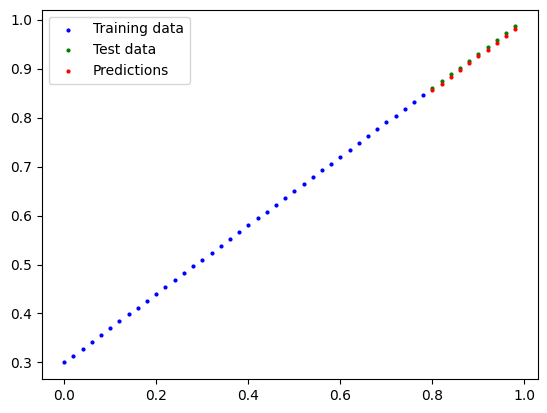

In [16]:
print(f"actual weights and bias: {weights, bias}")
print(f"weights and bias calculated by Gradient descent: {model.state_dict()}")
plot_predictions(predictions=y_pred.detach().numpy())

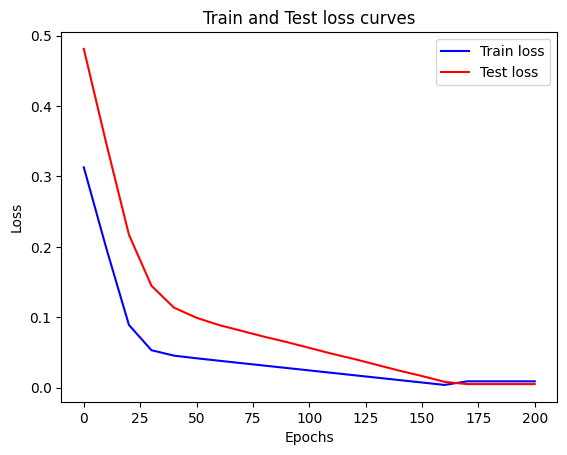

In [17]:
plt.plot(epoch_count, train_loss_vals, c='b', label='Train loss')
plt.plot(epoch_count, test_loss_vals, c='r', label='Test loss')
plt.title('Train and Test loss curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [18]:
MODEL_NAME = "model_0.pth"

# saving only the stae_dict values
torch.save(obj= model.state_dict(), f="models/"+MODEL_NAME)

In [19]:
# the following load method can't be used as we have only saved stae_dict
torch.load(f="models/"+MODEL_NAME)

# first create an instance of LR, basically a neural network to load the parameters from state_dict
loaded_model_0 = LinearRegression()

loaded_model_0.load_state_dict(torch.load(f="models/"+MODEL_NAME))

<All keys matched successfully>

In [20]:
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.6951])), ('bias', tensor([0.2993]))])

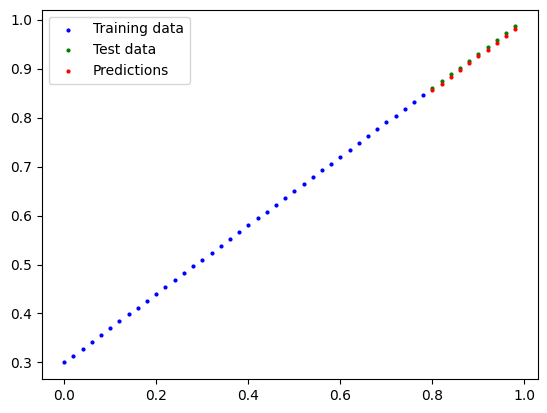

In [21]:
with torch.inference_mode():
    y_pred = loaded_model_0(X_test)

plot_predictions(predictions=y_pred)